#Aprendizaje Automático 2
### TP 2 - Redes Recurrentes
#### Problema 1 - Audio MNIST

## Enunciado

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

**Dataset:**
https://www.tensorflow.org/datasets/catalog/spoken_digit

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor.

**Objetivo:**

Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:
* Modelo convolucional sobre los espectrogramas de los clips.
* Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

**Entrega:**

Código fuente de la solución implementada en Google Colab, que incluya:
* Análisis previo y preprocesamiento del set de datos.
* Definición y entrenamiento del modelo.
* Resultados de la evaluación de los modelos, incluyendo métricas de desempeño y visualizaciones relevantes.


##Setup

Se importan las librerías y dependencias necesarias, y se fija el valor de la semilla para lograr reproducibilidad.

In [1]:
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import shutil
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.model_selection import train_test_split

# Configuración inicial
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
#!pip install -U tensorflow_datasets
#!pip install pydub
#!apt-get install ffmpeg -y
#from pydub import AudioSegment
#import random
#import tensorflow_datasets as tfds
#from tqdm import tqdm
#import wave

Establecer GPU por defecto en caso de estar disponible

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Carga de Datos

In [3]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [4]:
# Ruta donde están los audios
audio_path = '/content/free-spoken-digit-dataset/recordings'

# Verificación de archivos
audio_files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
print("Total de audios:", len(audio_files))
print("Ejemplo de archivos:", audio_files[:5])  # {digitLabel}_{speakerName}_{index}.wav

# Verificación de balance
labels = [fname.split('_')[0] for fname in audio_files]
counts = Counter(labels)
print("Distribución de clases:", counts.most_common())  # Ordenado por frecuencia

Total de audios: 3000
Ejemplo de archivos: ['6_theo_8.wav', '7_yweweler_33.wav', '6_yweweler_20.wav', '7_george_42.wav', '1_nicolas_2.wav']
Distribución de clases: [('6', 300), ('7', 300), ('1', 300), ('9', 300), ('2', 300), ('0', 300), ('4', 300), ('3', 300), ('8', 300), ('5', 300)]


Se cuentan los archivos de audio por dígito, observándose que el dataset está balanceado.

#### Creación del dataframe

In [5]:
data = []
for file in audio_files:
    try:
        data.append({
            'file': os.path.join(audio_path, file),
            'label': int(file.split('_')[0]),  # Convertir la etiqueta a int
            'speaker': file.split('_')[1],  # Extraemos el speaker
            'index': int(file.split('_')[2].split('.')[0])  # Extraemos el índice
        })
    except Exception as e:
        print(f"Error procesando archivo {file}: {str(e)}")

df = pd.DataFrame(data)

# Verificación adicional
print("\nMuestra del dataframe:")
print(df.head())
print("\nTipos de datos:")
print(df.dtypes)


Muestra del dataframe:
                                                file  label   speaker  index
0  /content/free-spoken-digit-dataset/recordings/...      6      theo      8
1  /content/free-spoken-digit-dataset/recordings/...      7  yweweler     33
2  /content/free-spoken-digit-dataset/recordings/...      6  yweweler     20
3  /content/free-spoken-digit-dataset/recordings/...      7    george     42
4  /content/free-spoken-digit-dataset/recordings/...      1   nicolas      2

Tipos de datos:
file       object
label       int64
speaker    object
index       int64
dtype: object


####Separación de datos en train y validation

In [6]:
# Creación estructurada de directorio
data_dir = 'organized_audio'
os.makedirs(data_dir, exist_ok=True)

for _, row in df.iterrows():
    label_dir = os.path.join(data_dir, str(row['label']))
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy2(row['file'], label_dir)

# Separación train test
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=8000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


##Análisis exploratorio

In [7]:
# Shapes
train_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
# Eliminación de eje extra
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Validación
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 8000)
(64,)


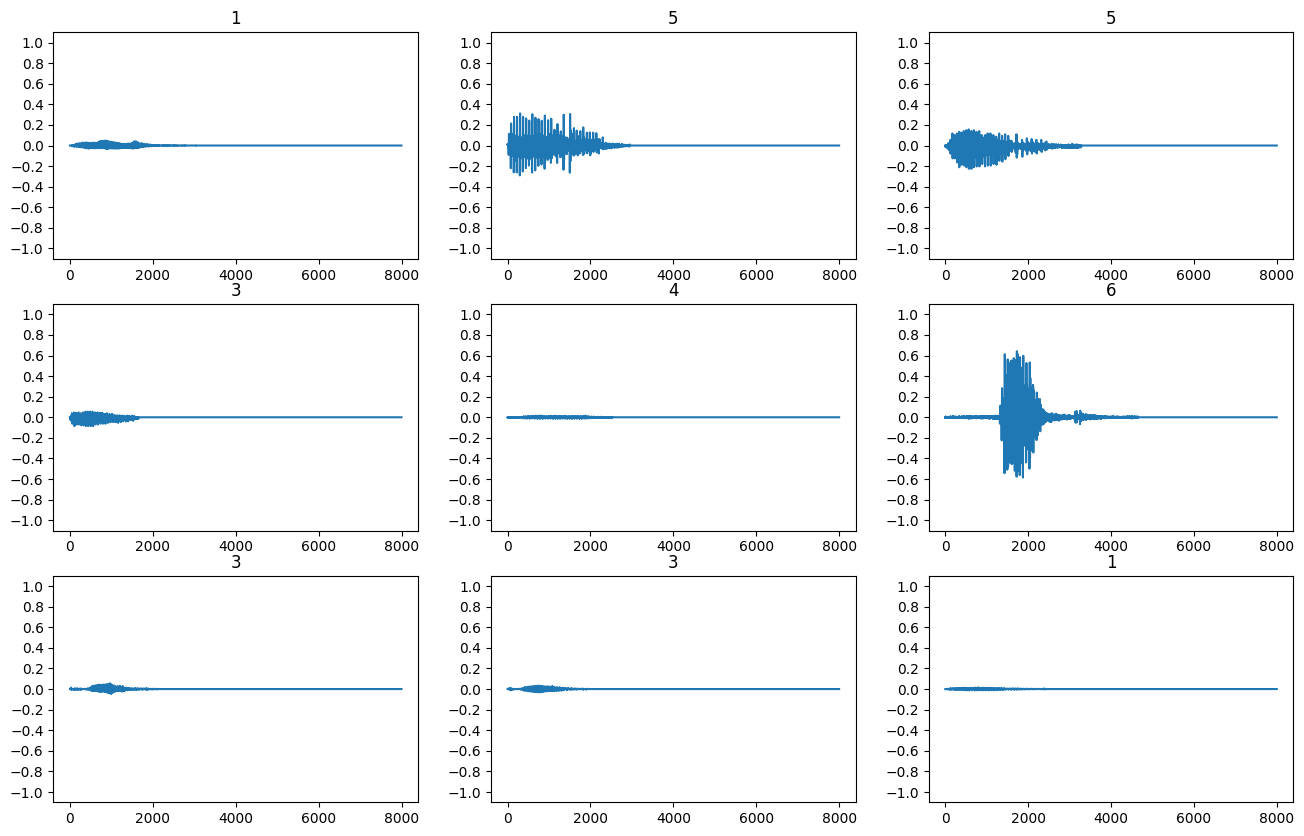

In [9]:
# Ploteamos la forma de onda para algunos ejemplos
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

##Conversión de formas de onda a espectrogramas

In [10]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT
  spectrogram = tf.abs(spectrogram)
  # Add a 'channels' dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape ('batch_size', 'height', 'width', 'channels').
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [12]:
# Label, Waveform shape, Spectogram shape, Audio playback

for i in range(10):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 5
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 5
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 3
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 4
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 6
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 3
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 3
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 9
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


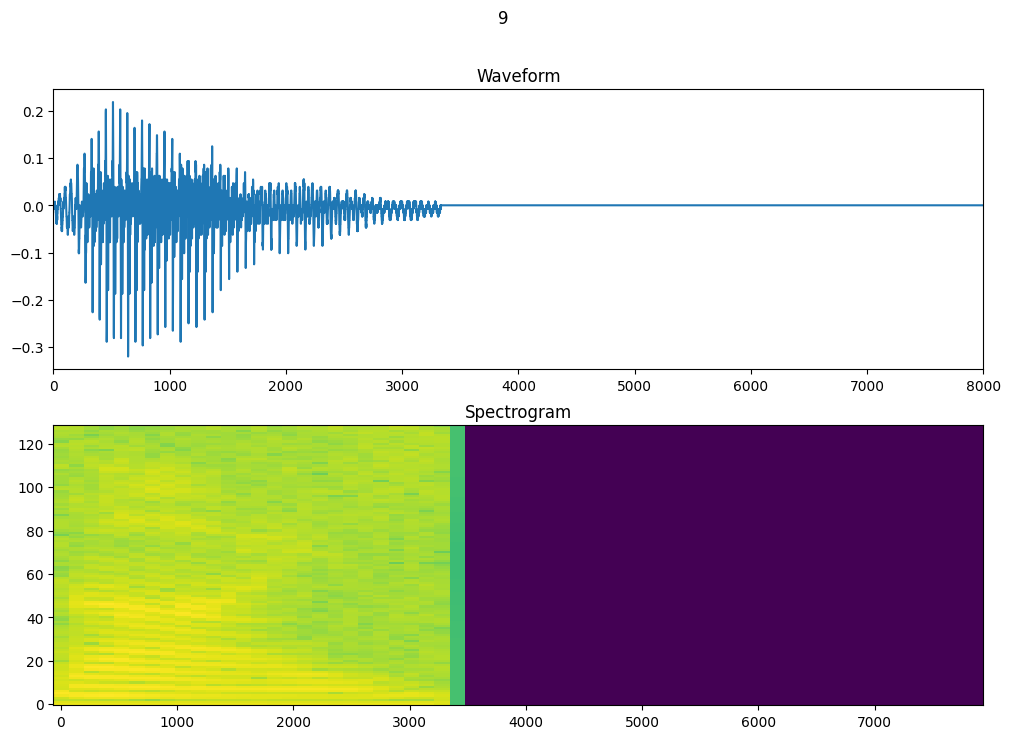

In [14]:
# Función para mostrar espectrograma

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [15]:
# Creación de un dataset de espectrogramas

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

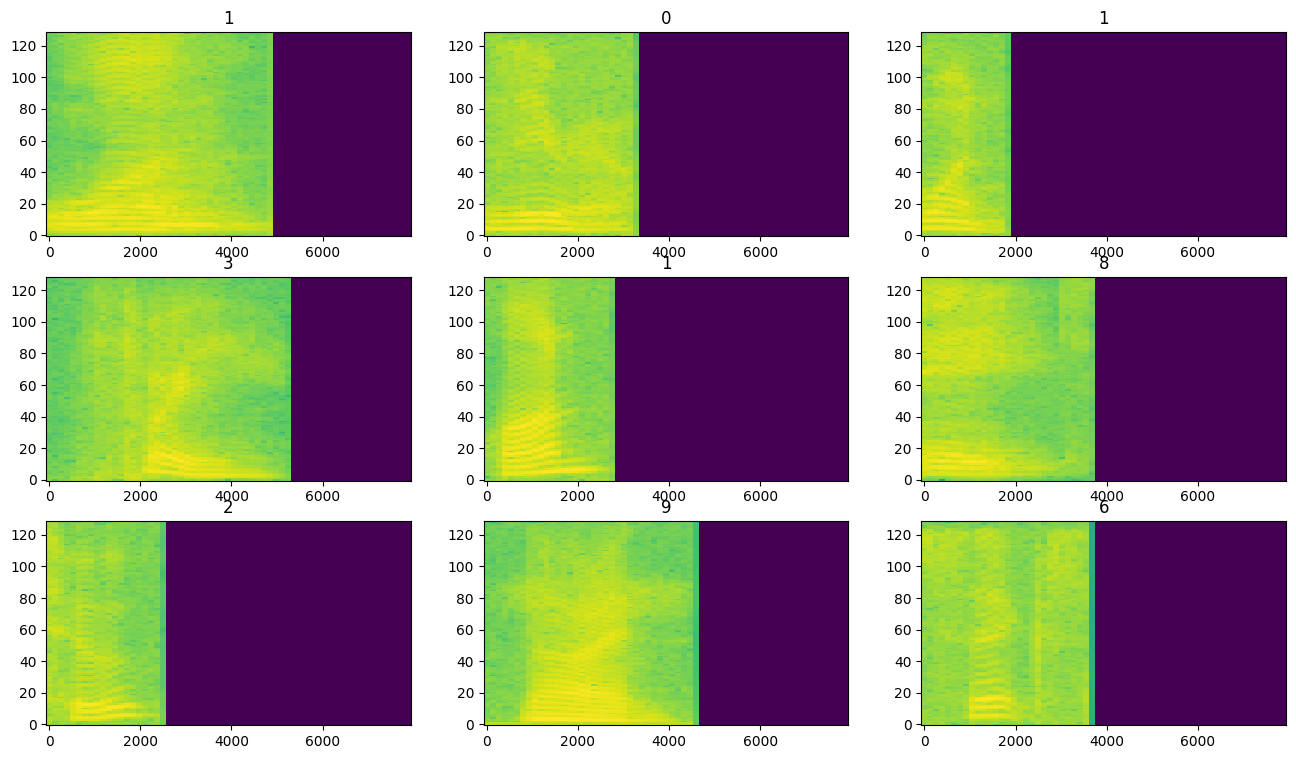

In [17]:
# Extracción de ejemplos del dataset
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1): # Obtiene el primer batch
  break

# Configuración de la figura
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

# Visualización de los espectrogramas
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

##CNN

###Arquitectura

Para el modelado se utilizará una red neuronal convolucional simple (CNN), a partir de las imágenes de espectrogramas generadas de los archivos de audio.

In [18]:
train_size = 2400
val_size = 600
shuffle_buffer = min(1000, train_size // 2)

# Optimización de la carga del dataset
train_spectrogram_ds = (train_spectrogram_ds
                       .cache()
                       .shuffle(shuffle_buffer)
                       .prefetch(tf.data.AUTOTUNE))

val_spectrogram_ds = (val_spectrogram_ds
                     .cache()
                     .prefetch(tf.data.AUTOTUNE))

In [26]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the 'tf.keras.layers.Normalization' layer
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms with 'Normalization.adapt'
# (calcula media y desviación estándar)
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input
    layers.Resizing(32, 32),
    # Normalize
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (61, 129, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [27]:
# Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

###Entrenamiento

In [28]:
# Entrenamiento con early stopping
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.2846 - loss: 2.0167 - val_accuracy: 0.6800 - val_loss: 1.1812
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.5927 - loss: 1.2304 - val_accuracy: 0.7883 - val_loss: 0.8247
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.6941 - loss: 0.9297 - val_accuracy: 0.8583 - val_loss: 0.5839
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.7896 - loss: 0.6459 - val_accuracy: 0.8783 - val_loss: 0.4695
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.8224 - loss: 0.5485 - val_accuracy: 0.9083 - val_loss: 0.3645
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.8527 - loss: 0.4525 - val_accuracy: 0.9033 - val_loss: 0.3010
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.8812 - loss: 0.3843 - val_accuracy: 0.9333 - val_loss: 0.2631
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.8922 - loss: 0.3411 - val_accuracy: 

###Resultados

Text(0, 0.5, 'Accuracy [%]')

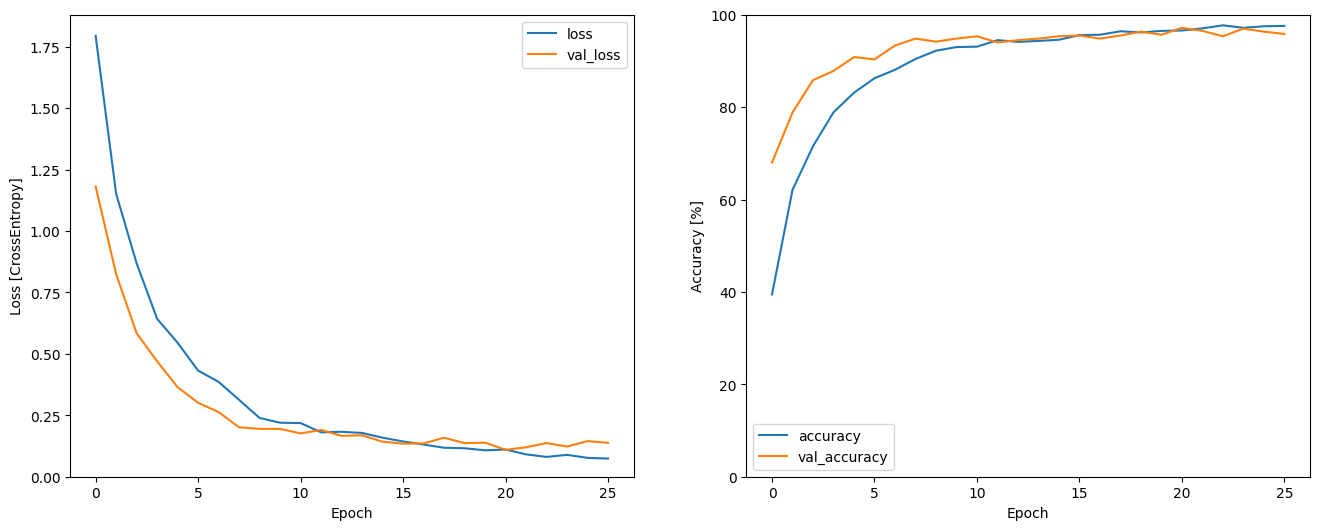

In [29]:
# Ploteo de resultados
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

La pérdida (loss) disminuye consistentemente con el aumento de las épocas, lo que indica que el modelo está aprendiendo durante el entrenamiento.
La pérdida de validación (val_loss) también disminuye al principio, pero se estabiliza y comienza a fluctuar a partir de la época 16, indicando un posible sobreajuste, ya que la pérdida de validación deja de mejorar mientras que la de entrenamiento sigue disminuyendo.

La precisión de entrenamiento (accuracy) sigue aumentando con cada época, alcanzando un valor alto del 97,56%.
La precisión de validación (val_accuracy) aumenta inicialmente, pero se estabiliza y muestra fluctuaciones alrededor del 95%.

El modelo logra un buen rendimiento en los datos de entrenamiento y generaliza muy bien en los datos de validación.

In [30]:
# Guardar el modelo como un archivo HDF5
model.save("model_cnn.h5")

####Matriz de confusión

Se utiliza una matriz de confusión para verificar qué tan bien clasificó el modelo cada uno de los dígitos en el conjunto de validación:

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


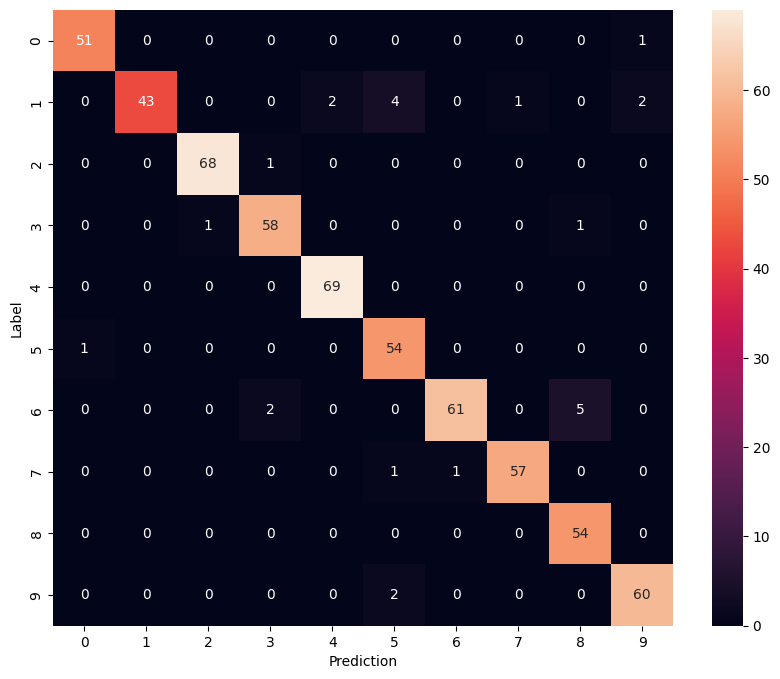

In [31]:
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

**Rendimiento por clase:**

* Clases como 4 y 8 tienen alta precisión. También 0, 2 y 5.

* Clases como 1 y 6 tienen más errores (valores dispersos fuera de la diagonal).

**Errores comunes:**

* La clase 1 se confunde con 5, 4, 9 y 7.

* La clase 6 se confunde con 8 y 3.

####Predicción de audio

Se realiza una comprobación aleatoria de clasificación sobre el dataset original.

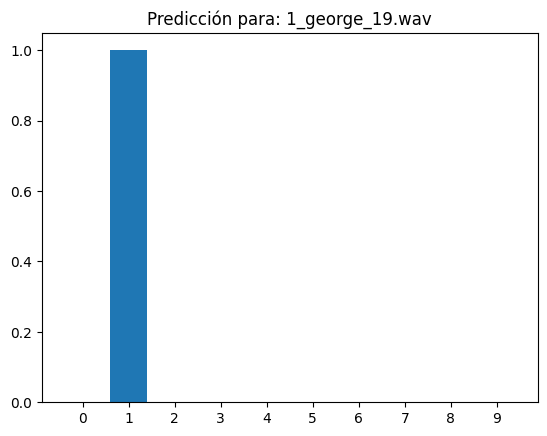

In [45]:
from pathlib import Path
data_dir = Path('organized_audio')  # Convertir a objeto Path
audio_path = data_dir / '1' / '1_george_19.wav'

# Cargar y procesar el audio
x = tf.io.read_file(str(audio_path))  # Convertir a string para tf.io.read_file
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
x = tf.squeeze(x, axis=-1)
waveform = x

# Obtener el espectrograma
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

# Realizar predicción
prediction = model(x)
x_labels = label_names

# Visualizar resultados
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predicción para: 1_george_19.wav')
plt.show()

# Reproducir audio
display.display(display.Audio(waveform, rate=8000))

##RNN

In [46]:
# Preprocesamiento

def preprocess_rnn_data(spectrogram, label):
    """
    Preprocesa los datos para su uso en una red recurrente (RNN).

    Este preprocesamiento incluye la eliminación de dimensiones redundantes,
    submuestreo temporal para reducir la longitud de las secuencias, y la
    normalización de los valores para mejorar el rendimiento del modelo.

    Args:
        spectrogram (tf.Tensor): Tensor del espectrograma con forma
                                 (batch, tiempo, características, canal).
                                 Normalmente, el canal es redundante y tiene un valor de 1.
        label (tf.Tensor): Etiqueta asociada a cada espectrograma, sin modificaciones.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]:
            - spectrogram: Tensor preprocesado con forma (batch, 500, características).
              Los valores están normalizados (media 0, desviación estándar 1).
            - label: Etiqueta correspondiente al espectrograma, sin cambios.
    """
    # Eliminar la dimensión del canal redundante
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # De (batch, 999, 129, 1) a (batch, 999, 129)

    # Submuestreo temporal: Mantener solo las primeras 500 secuencias
    spectrogram = spectrogram[:, :500, :]

    # Normalización del espectrograma
    mean = tf.reduce_mean(spectrogram)
    std = tf.math.reduce_std(spectrogram)
    spectrogram = (spectrogram - mean) / std

    return spectrogram, label

In [47]:
for spec, _ in train_spectrogram_ds.take(1):
    print(f"Forma del espectrograma: {spec.shape}")

Forma del espectrograma: (64, 61, 129, 1)


In [48]:
train_rnn_ds = train_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)
val_rnn_ds = val_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)

###Arquitectura

Se diseña una red recurrente para la clasificación de audio.

In [49]:
# Definición del modelo
model_rnn = models.Sequential([
    layers.Input(shape=(500, 129)),  # Forma: (timesteps, features)

    # Primera capa recurrente
    layers.LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),

    # Segunda capa recurrente
    layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1),

    # Capa densa
    layers.Dense(64, activation='relu'),

    # Regularización
    layers.Dropout(0.5),

    # Capa de salida
    layers.Dense(num_labels, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Compilar el modelo
model_rnn.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model_rnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 500, 256)       │       395,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,290 (2.29 MB)

 Trainable params: 601,290 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

###Entrenamiento

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 889ms/step - accuracy: 0.1123 - loss: 2.3104 - val_accuracy: 0.1017 - val_loss: 2.3019
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 846ms/step - accuracy: 0.1054 - loss: 2.3060 - val_accuracy: 0.1517 - val_loss: 2.2600
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 871ms/step - accuracy: 0.1410 - loss: 2.2643 - val_accuracy: 0.1600 - val_loss: 2.2097
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 875ms/step - accuracy: 0.1699 - loss: 2.1757 - val_accuracy: 0.2467 - val_loss: 2.0845
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 898ms/step - accuracy: 0.2496 - loss: 2.0446 - val_accuracy: 0.3650 - val_loss: 1.7527
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 847ms/step - accuracy: 0.3817 - loss: 1.6939 - val_accuracy: 0.5083 - val_loss: 1.3825
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 879ms/step - accuracy: 0.4421 - loss: 1.5264 - val_accuracy: 0.5400 - val_loss: 1.1590
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 898ms/step - accuracy: 0.5182 - loss: 1.3484 - val_accu

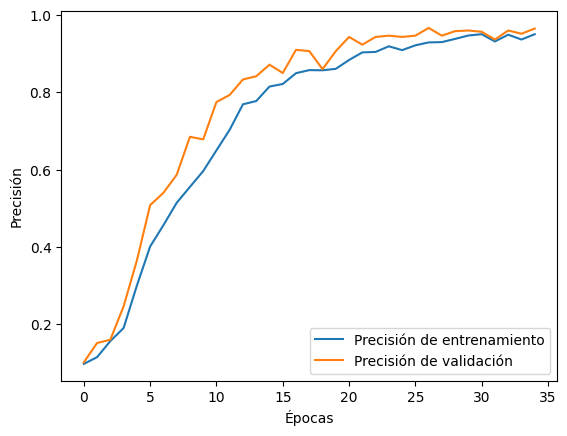

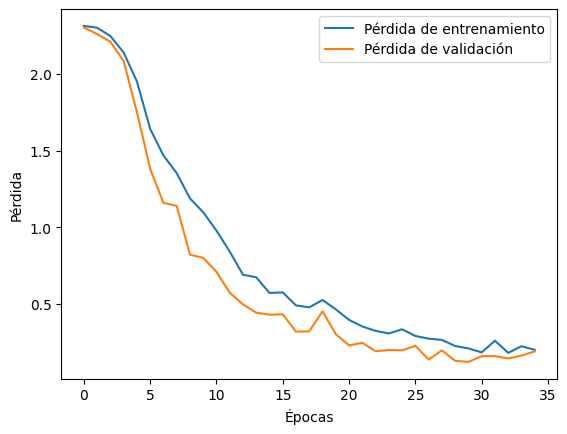

In [50]:
history_rnn = model_rnn.fit(
    train_rnn_ds,
    validation_data=val_rnn_ds,
    epochs= EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5,restore_best_weights=True)
)

# Obtener el índice de la mejor época restaurada
best_epoch_index = history_rnn.history['val_loss'].index(min(history_rnn.history['val_loss']))

# Mostrar las métricas de la mejor época
print(f"Mejor Época Restaurada: {best_epoch_index + 1}")
print(f"Entrenamiento - Loss: {history_rnn.history['loss'][best_epoch_index]:.4f}, Accuracy: {history_rnn.history['accuracy'][best_epoch_index]:.4f}")
print(f"Validación - Loss: {history_rnn.history['val_loss'][best_epoch_index]:.4f}, Accuracy: {history_rnn.history['val_accuracy'][best_epoch_index]:.4f}")

# Precisión
plt.plot(history_rnn.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Pérdida
plt.plot(history_rnn.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_rnn.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

###Resultados

La pérdida (loss) disminuye consistentemente con el aumento de las épocas, lo que indica que el modelo está aprendiendo durante el entrenamiento.A partir de la épica 30 comienza a fluctuar.
La pérdida de validación (val_loss) también disminuye pero se estabiliza y comienza a fluctuar a partir de la época 25.

La precisión de entrenamiento (accuracy) sigue aumentando hasta la época 31, alcanzando un valor máximo del 96,29%.
La precisión de validación (val_accuracy) también mejora, alcanzando un valor máximo del 96.97%. Se estabiliza sobre la época 33.

El modelo restauró los pesos de la mejor época (30), con las siguientes métricas:

Entrenamiento:
*   Pérdida (loss): 0.2103
*   Precisión (accuracy): 94,71%

Validación:
*   Pérdida (val_loss): 0.1223
*   Precisión (val_accuracy): 96.00%

In [51]:
# Se guarda el modelo como un archivo HDF5
model_rnn.save("model_rnn.h5")

####Matriz de confusión

Se utiliza una matriz de confusión para verificar qué tan bien clasificó el modelo cada uno de los dígitos en el conjunto de validación:

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step


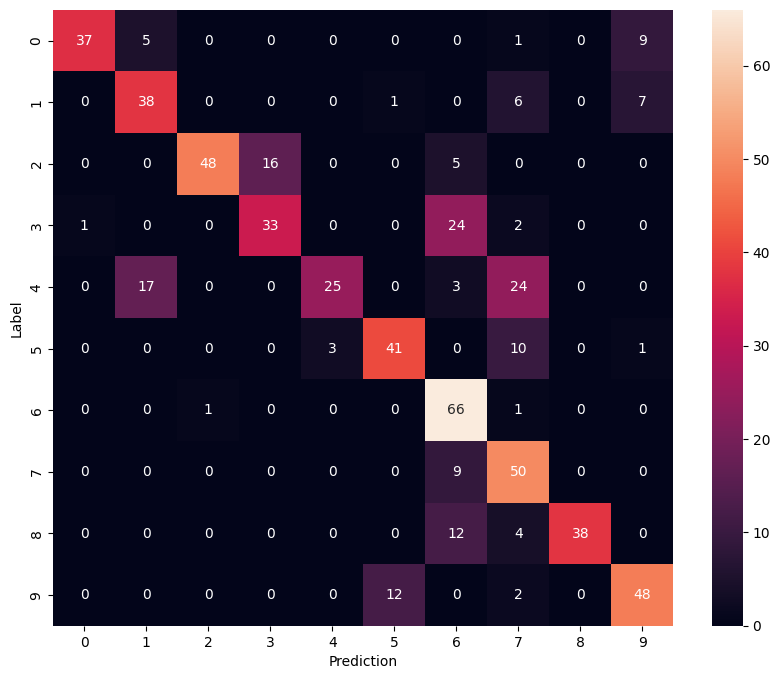

In [52]:
y_pred_rnn = model_rnn.predict(val_spectrogram_ds)
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)
y_true_rnn = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

####Predicción de audio

Se realiza una comprobación aleatoria de clasificación sobre el dataset original.

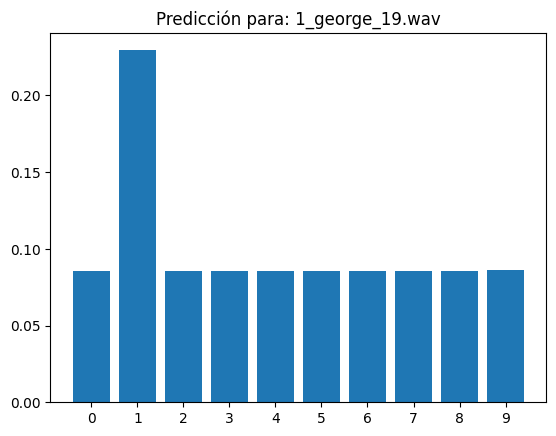

In [53]:
from pathlib import Path
data_dir = Path('organized_audio')  # Convertir a objeto Path
audio_path = data_dir / '1' / '1_george_19.wav'

# Cargar y procesar el audio
x = tf.io.read_file(str(audio_path))  # Convertir a string para tf.io.read_file
#x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=N*8000)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
x = tf.squeeze(x, axis=-1)
waveform = x

# Obtener el espectrograma
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

# Realizar predicción
prediction = model_rnn(x)
x_labels = label_names

# Visualizar resultados
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predicción para: 1_george_19.wav')
plt.show()

# Reproducir audio
display.display(display.Audio(waveform, rate=8000))

###SEGUNDO INTENTO

Forma del espectrograma de ejemplo: (64, 61, 129, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 61, 256)        │       395,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,802 (2.30 MB)

 Trainable params: 601,546 (2.29 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.1483 - loss: 2.6627 - val_accuracy: 0.1517 - val_loss: 2.2961 - learning_rate: 5.0000e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 884ms/step - accuracy: 0.1634 - loss: 2.4025 - val_accuracy: 0.1300 - val_loss: 2.2663 - learning_rate: 5.0000e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 943ms/step - accuracy: 0.2358 - loss: 2.0711 - val_accuracy: 0.2367 - val_loss: 2.1542 - learning_rate: 5.0000e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 858ms/step - accuracy: 0.2981 - loss: 1.9312 - val_accuracy: 0.5283 - val_loss: 1.7681 - learning_rate: 5.0000e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 938ms/step - accuracy: 0.4260 - loss: 1.5353 - val_accuracy: 0.4933 - val_loss: 1.4415 - learning_rate: 5.0000e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 904ms/step - accuracy: 0.4805 - loss: 1.3189 - val_accuracy: 0.4967 - val_loss: 1.2414 - learning_rate: 5.0000e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 860ms/step - accura

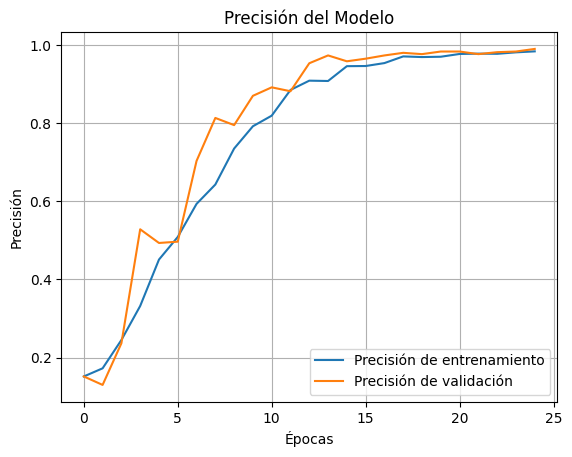

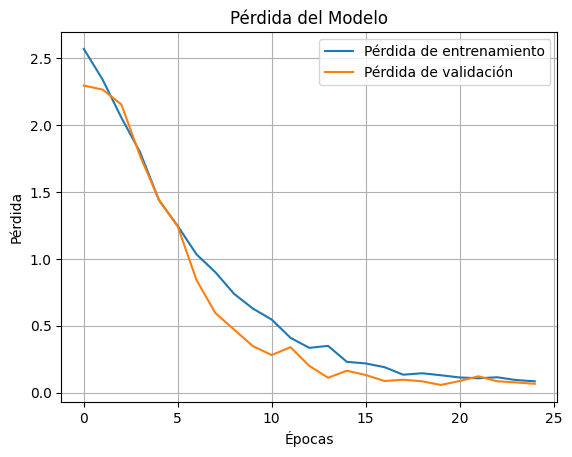

In [54]:
# ---------- Preprocesamiento ----------
def preprocess_rnn_data(spectrogram, label):
    """
    Preprocesa los datos para una RNN:
    - Elimina la dimensión del canal
    - Normaliza por muestra
    """
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # De (batch, tiempo, características, 1) a (batch, tiempo, características)

    # Normalización por muestra
    mean = tf.reduce_mean(spectrogram, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(spectrogram, axis=[1, 2], keepdims=True)
    spectrogram = (spectrogram - mean) / (std + 1e-6)  # Añadir epsilon para evitar división por cero

    return spectrogram, label

# Mostrar forma de ejemplo
for spec, _ in train_spectrogram_ds.take(1):
    print(f"Forma del espectrograma de ejemplo: {spec.shape}")

# Aplicar el preprocesamiento
train_rnn_ds = train_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)
val_rnn_ds = val_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)

# ---------- Definición del modelo ----------
input_shape = next(iter(train_rnn_ds.take(1)))[0].shape[1:]  # (timesteps, features)

model_rnn = models.Sequential([
    layers.Input(shape=input_shape),  # input_shape: (tiempo, características)

    # Primera capa LSTM
    layers.LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),

    # Segunda capa LSTM
    layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1),

    # Batch Normalization
    layers.BatchNormalization(),

    # Capa densa + Dropout
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Capa de salida
    layers.Dense(num_labels, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model_rnn.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_rnn.summary()

# ---------- Callbacks ----------
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )
]

# ---------- Entrenamiento ----------
history_rnn = model_rnn.fit(
    train_rnn_ds,
    validation_data=val_rnn_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ---------- Mejor época ----------
best_epoch_index = history_rnn.history['val_loss'].index(min(history_rnn.history['val_loss']))

print(f"\nMejor Época Restaurada: {best_epoch_index + 1}")
print(f"Entrenamiento - Loss: {history_rnn.history['loss'][best_epoch_index]:.4f}, Accuracy: {history_rnn.history['accuracy'][best_epoch_index]:.4f}")
print(f"Validación - Loss: {history_rnn.history['val_loss'][best_epoch_index]:.4f}, Accuracy: {history_rnn.history['val_accuracy'][best_epoch_index]:.4f}")

# ---------- Gráficos ----------
plt.plot(history_rnn.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión del Modelo')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(history_rnn.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_rnn.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida del Modelo')
plt.grid(True)
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


<Figure size 800x600 with 0 Axes>

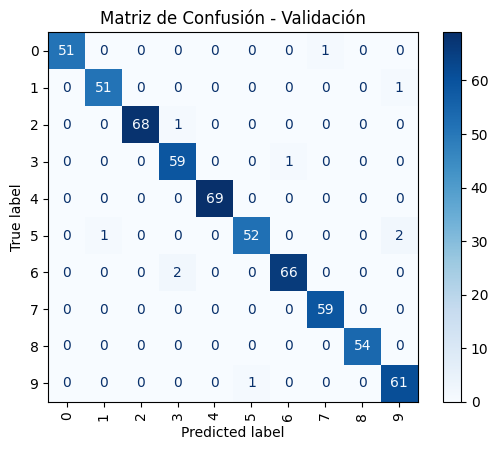

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---------- Predicciones y etiquetas verdaderas ----------
y_true = []
y_pred = []

for spectrograms, labels in val_rnn_ds:
    preds = model_rnn.predict(spectrograms)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ---------- Matriz de Confusión ----------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matriz de Confusión - Validación")
plt.grid(False)
plt.show()


## Conclusiones

Preguntas disparadoras:

Cuál de las dos arquis obtuvo mejor desempeño?

Cuántos hiperparámetros tiene cada una?

Cuál es más eficiente en cuanto a tiempos de entrenamiento?

Cuál generaliza mejor?